In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import dill

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

import gm2
import trfp
import plotting_functions as plt2
# import analysis_helper as helper
# import helper_function_candidates as helper_old
# import df_analysis_funcs as df_func
import helper_functions as helper

import field_map_config_run1 as map_config

from IPython.display import clear_output

# blinds = np.loadtxt('blinds.txt')
pair_dict = map_config.pair_dict

Welcome to JupyROOT 6.22/02


In [60]:
fig_width = 3.375 * 2  # inches, two column

plt.style.use('gm2.mplstyle')

In [3]:
run = '1a'

filename = 'hdf5/2020-09-30_run_' + run + '.h5'

interp_dfs, keys, subrun_df = helper.read_dfs(filename)
run_pair_dict = pair_dict[run]

moment_dfs = helper.interp_to_moment(interp_dfs, keys)
# moment_dfs = blind_moments(moment_dfs, keys, blinds)
corrected_dfs = helper.moment_to_corrected(moment_dfs, keys)

baselines = helper.station_average(corrected_dfs, keys)

## for endgame only
# for item in baselines:
#     baselines[item]['tr_df_9'] = baselines[item]['tr_df_8']
# baselines['time']['tr_df_9'] = baselines['time']['tr_df_7']

vtm_dfs = helper.calculate_vtms(corrected_dfs, keys, baselines, run_pair_dict)

bloch_style_dfs = helper.bloch_style_moments(corrected_dfs, keys)
baselines_bloch = helper.station_average(bloch_style_dfs, keys)

## for endgame only
# for item in baselines_bloch:
#     baselines_bloch[item]['tr_df_9'] = baselines_bloch[item]['tr_df_8']
# baselines_bloch['time']['tr_df_9'] = baselines_bloch['time']['tr_df_7']

vtm_dfs_bloch = helper.calculate_vtms(bloch_style_dfs, keys, baselines_bloch, run_pair_dict)

# clear_output()

# for key in vtm_dfs.keys():
#     a = vtm_dfs[key].index.values
#     bins = np.array([a,a]).T.flatten()[:len(a)]

#     vtm_2_sec_df = vtm_dfs_bloch[key].groupby(bins).mean()
#     vtm_2_sec_df = vtm_2_sec_df.set_index((a[::2]+0.5))

#     weight = trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1]
#     weight[2] = weight[2] + 360

#     vtm_2_sec_azi_avg_df = pd.DataFrame(index=vtm_2_sec_df.index)

#     for m in range(9):
#         stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
#         vtm_2_sec_azi_avg_df['m'+str(m+1)] = vtm_2_sec_df[stm_list].multiply(weight).sum(axis=1)/360

#     # need to save 4 data frames

#     save_key = 'run_' + run + key[6]
#     save_dir = 'hdf5/'
#     save_prefix = '2020-09-30_'

#     print 'Saving ' + save_key

#     # save purcell style

#     save_path = save_dir + save_prefix + 'purcell_maps.h5'
#     vtm_dfs[key].to_hdf(save_path, key=save_key)

#     # save hybrid

#     save_path = save_dir + save_prefix + 'hybrid_maps.h5'
#     vtm_dfs_bloch[key].to_hdf(save_path, key=save_key)

#     # save 2 sec hybrid

#     save_path = save_dir + save_prefix + 'hybrid_maps_2sec.h5'
#     vtm_2_sec_df.to_hdf(save_path, key=save_key)

#     # save 2 sec azi avg hybrid

#     save_path = save_dir + save_prefix + 'hybrid_maps_2sec_aziavg.h5'
#     vtm_2_sec_azi_avg_df.to_hdf(save_path, key=save_key)


Reading fp_df_1

Reading tr_df_1

Reading tr_df_2

Calculating moments for fp_df_1
Finished calculating all moments for 257281 events.   

Calculating moments for tr_df_1
Finished calculating all moments for 4386 events.

Calculating moments for tr_df_2
Finished calculating all moments for 4363 events.

Removing trolley footprints for tr_df_1
Removing trolley image from station 71.              
Removing trolley footprints for tr_df_2
Removing trolley image from station 71.              


Calculating trolley run baselines.

Calculating VTMs

Implementing Bloch-style treatment of stations 1, 3, and 5.
fp_df_1
tr_df_1
tr_df_2
m5
Calculating trolley run baselines.

Calculating VTMs


In [4]:
def bins(df, num_bins):
    xy_df = df.groupby(pd.cut(df.index.values, num_bins)).mean()
    x = np.empty(xy_df.size)
    ii = 0
    for interval in xy_df.index:
        x[ii] = interval.mid
        ii = ii + 1
    y = xy_df.values
    return x, y

Removing trolley image from station 10.


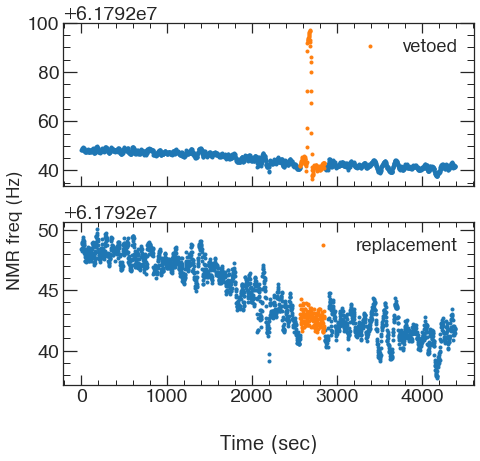

In [61]:
## fig:footprint_replacement

fig_name = 'fig_footprint_replacement'

st = 10
m = 1
df = 'tr_df_1'

veto_extent=25
no_mask_df = moment_dfs[df].copy()
t0 = no_mask_df.index.values[0]
no_mask_df.index -= t0
index = no_mask_df.index.values

print '\rRemoving trolley image from station '+str(st)+'.',

# veto when trolley is close to station

veto_low = (trfp.STATION_BARCODE_PHI[st]-1.5-veto_extent/2)%360
veto_high = (trfp.STATION_BARCODE_PHI[st]-1.5+veto_extent/2)%360
if veto_low < veto_high:
    veto_mask = (no_mask_df['tr_phi']>veto_low) & (no_mask_df['tr_phi']<veto_high)
else:  # this happens when wrapping around 360 deg
    veto_mask = (no_mask_df['tr_phi']>veto_low) | (no_mask_df['tr_phi']<veto_high)

# no longer dealing with m6 in the fixed probes


stm = 'st'+str(st)+',m'+str(m)

# calculate local drift

times = no_mask_df.index.values[~veto_mask]
freqs = no_mask_df[stm][~veto_mask]

local_drift_fit = np.polyfit(times, freqs, 5)
local_drift = np.polyval(local_drift_fit, no_mask_df.index.values)

# need to average other side of ring
all_good_stations = np.arange(6,72)  # not using the inflector stations
no_ground_loop_stations = np.array(range(6,16)+range(64,72))  # vaid for 25 deg veto

# next need to average all good stations that are not within 3 of current station
if st not in range(16, 23):  # note that these ranged were chosen for 25 deg veto
    averaging_stations = np.delete(all_good_stations,
                                   np.argwhere((np.abs((all_good_stations - st)%72)<=3)
                                              | (np.abs((all_good_stations - st)%72)>=69))
                                  )
else:
    averaging_stations = np.delete(no_ground_loop_stations,
                                   np.argwhere((np.abs((no_ground_loop_stations - st)%72)<=3)
                                              | (np.abs((no_ground_loop_stations - st)%72)>=69))
                                  )
avg_stms = ['st'+str(avg_st)+',m'+str(m+1) for avg_st in averaging_stations]
replacement = no_mask_df[avg_stms].mean(axis=1)

# calculate global drift
global_drift_fit = np.polyfit(index[veto_mask], replacement[veto_mask], 1)
global_drift = np.polyval(global_drift_fit, index[veto_mask])

# subtract global drift from replacement
replacement = replacement[veto_mask] - global_drift

# add local drift
replacement = replacement + local_drift[veto_mask]

no_mask_df[stm][veto_mask] = replacement

raw_data = moment_dfs[df][stm].copy()
raw_data.index -= raw_data.index.values[0]

x0, y0 = bins(raw_data[~veto_mask], raw_data[~veto_mask].size/2)
x3, y3 = bins(raw_data[veto_mask], raw_data[veto_mask].size/2)

unvetoed = no_mask_df[stm][~veto_mask].copy()
x1, y1 = bins(unvetoed, unvetoed.size/2)
replace = no_mask_df[stm][veto_mask].copy()
x2, y2 = bins(replace, replace.size/2)

fig2, axs2 = plt.subplots(2, 1, sharex=True)

axs2[0].plot(x0, y0+61.74e6, '.', ms=6)
axs2[0].plot(x3, y3+61.74e6, '.', ms=6, label='vetoed')
axs2[0].legend()

axs2[1].plot(x1, y1+61.74e6, '.', ms=6)
axs2[1].plot(x2, y2+61.74e6, '.', ms=6, label='replacement')
axs2[1].legend()

axs2[1].set_xlabel('Time (sec)')

fig2.text(0, 0.5, 'NMR freq (Hz)', va='center', rotation='vertical')

fig2.set_size_inches(fig_width, fig_width)
fig2.tight_layout()

fig2.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
pickle.dump(axs2, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

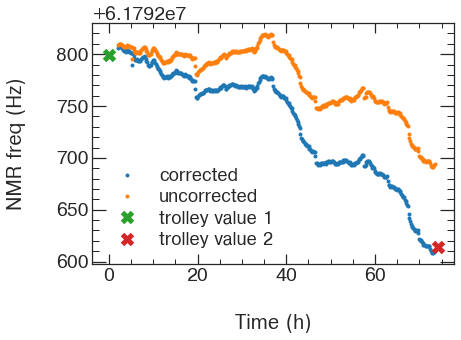

In [62]:
## fig:backward_interp
fig_name = 'fig_backward_interp'

fig1, axs1 = plt.subplots(1,1)

st = 42
m = 1

df = 'fp_df_1'
stm = 'st'+str(st)+',m'+str(m)
stm5 = 'st'+str(st)+',m5'

x0 = 0
x1 = (baselines['time']['tr_df_2'][st] - baselines['time']['tr_df_1'][st])/3600.


pre_corr = (moment_dfs[df][stm] - baselines['fp']['tr_df_1'][st,m-1] + baselines['tr']['tr_df_1'][st,m-1]
            + 2.631605 * (moment_dfs[df][stm5] - baselines['fp']['tr_df_1'][st,4])
           )
x, pre_corr = bins(pre_corr, pre_corr.size/600)
post_corr = vtm_dfs[df][stm]
_, post_corr = bins(post_corr, post_corr.size/600)

x = x - baselines['time']['tr_df_1'][st]
x = x/3600.



axs1.plot(x, post_corr+61.74e6, '.', markersize=6, label='corrected')
axs1.plot(x, pre_corr+61.74e6, '.', markersize=6, label='uncorrected')

axs1.plot(x0, baselines['tr']['tr_df_1'][st,m-1]+61.74e6, 'x', color='C2', mew=5, markersize=10, label='trolley value 1')
axs1.plot(x1, baselines['tr']['tr_df_2'][st,m-1]+61.74e6, 'x', color='C3', mew=5, markersize=10, label='trolley value 2')

axs1.legend()

axs1.set_xlabel('Time (h)')
axs1.set_ylabel('NMR freq (Hz)')

fig1.set_size_inches(fig_width,0.75*fig_width)
fig1.tight_layout()

fig1.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
pickle.dump(axs1, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

In [63]:
## fig:team_diffs

fig_name = 'fig_team_diffs'

bloch_df = pd.read_csv('/data2/scharity/Run1/FinalUnblindingOct2020/60Hr_3956-3997_for_alec.csv', index_col=0)
purcell_df = pd.read_hdf('/data2/aetb/2020-09-30_purcell_maps.h5', key='run_1a1')

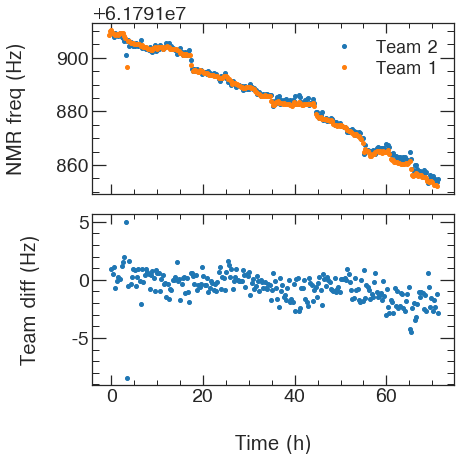

In [65]:
weight = (trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1])
weight[2] = (weight[2] + 360)
weight = weight/360

for m in range(9):
    stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
    purcell_df['m'+str(m+1)] = purcell_df[stm].multiply(weight).sum(axis=1)

fig3, axs3 = plt.subplots(2, 1, sharex=True)

xp, yp = bins(purcell_df['m1'], num_bins=purcell_df['m1'].size/1000)
xb, yb = bins(bloch_df['dipole'], num_bins=bloch_df['dipole'].size/1)
yb *= 61.79

xd = xp
yd = np.interp(xp, xb, yb) - yp

xb = (xb - xp[0])/3600
xd = (xd - xp[0])/3600
xp = (xp - xp[0])/3600

axs3[0].plot(xp, yp + 61.74e6, '.', label='Team 2')
axs3[0].plot(xb, yb + 61.74e6, '.', label='Team 1')
axs3[0].legend()
axs3[1].plot(xd, yd, '.')

axs3[0].set_ylabel('NMR freq (Hz)')
axs3[1].set_ylabel('Team diff (Hz)')
axs3[1].set_xlabel('Time (h)')

fig3.set_size_inches(fig_width, fig_width)
fig3.tight_layout()

fig3.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
pickle.dump(axs3, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

In [67]:
## fig:team_diffs_avg

fig_name = 'fig_team_diffs_avg'

bloch_purcell_dict = {'run_1a1':'/data2/scharity/Run1/FinalUnblindingOct2020/60Hr_3956-3997_for_alec.csv',
                      'run_1b1':'/data2/scharity/Run1/FinalUnblindingOct2020/HighKick_4058-4098_for_alec.csv',
                      'run_1b2':'/data2/scharity/Run1/FinalUnblindingOct2020/HighKick_4098-4138_for_alec.csv',
                      'run_1c1':'/data2/scharity/Run1/FinalUnblindingOct2020/9day_4138-4181_for_alec.csv',
                      'run_1c2':'/data2/scharity/Run1/FinalUnblindingOct2020/9day_4189-4226_for_alec.csv',
                      'run_1c3':'/data2/scharity/Run1/FinalUnblindingOct2020/9day_4226-4265_for_alec.csv',
                      'run_1d2':'/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5054-5103_for_alec.csv',
                      'run_1d3':'/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5117-5157_for_alec.csv',
                      'run_1d4':'/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5169-5217_for_alec.csv',
                      'run_1d5':'/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5217-5259_for_alec.csv',
                      'run_1d6':'/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5259-5303_for_alec.csv'}

bloch_avg = np.empty(11)
purc_avg = np.empty(11)
diff_avg = np.empty(11)

weight = (trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1])
weight[2] = (weight[2] + 360)
weight = weight/360

ii = 0
for run in bloch_purcell_dict:
    print run
    bloch_df = pd.read_csv(bloch_purcell_dict[run], index_col=0)
    purcell_df = pd.read_hdf('/data2/aetb/2020-09-30_purcell_maps.h5', key=run)
    for m in range(9):
        stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
        purcell_df['m'+str(m+1)] = purcell_df[stm].multiply(weight).sum(axis=1)
    xp, yp = bins(purcell_df['m1'], num_bins=purcell_df['m1'].size/1000)
    xb, yb = bins(bloch_df['dipole'], num_bins=bloch_df['dipole'].size/1)
    yb *= 61.79

    xd = xp
    yd = np.interp(xp, xb, yb) - yp

    xb = (xb - xp[0])/3600
    xd = (xd - xp[0])/3600
    xp = (xp - xp[0])/3600
    
    bloch_avg[ii] = np.polyfit(xb, yb, 0)
    purc_avg[ii] = np.polyfit(xp, yp, 0)
    diff_avg[ii] = np.polyfit(xd, yd, 0)
    
    ii += 1


run_1d4
run_1d5
run_1d6
run_1d2
run_1d3
run_1a1
run_1b2
run_1b1
run_1c1
run_1c3
run_1c2


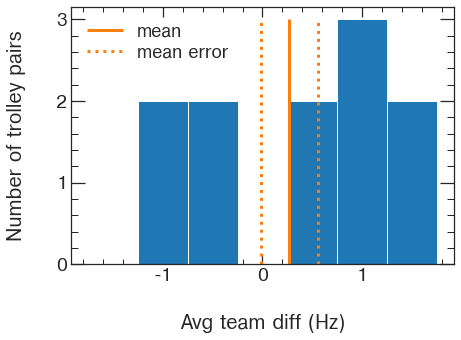

In [101]:
fig_name = 'fig_team_diffs_avg'

fig4, axs4 = plt.subplots(1,1)

axs4.hist(diff_avg, bins=np.arange(-1.75, 2, 0.5))
axs4.vlines(np.mean(diff_avg), 0, 3, color='C1', linewidths=3, label='mean')
axs4.vlines(np.mean(diff_avg) - np.std(diff_avg)/np.sqrt(11), 0, 3, color='C1', linewidths=3, linestyles='dotted', label='mean error')
axs4.vlines(np.mean(diff_avg) + np.std(diff_avg)/np.sqrt(11), 0, 3, color='C1', linewidths=3, linestyles='dotted')
axs4.legend()

axs4.set_xlabel('Avg team diff (Hz)')
axs4.set_ylabel('Number of trolley pairs')
axs4.set_yticks([0,1,2,3])

fig4.set_size_inches(fig_width, 0.75*fig_width)
fig4.tight_layout()

fig4.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
pickle.dump(axs4, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

In [112]:
## fig:run1_track

fig_name = 'fig_run1_track'

x = np.empty(0)
y1 = np.empty(0)
y2 = np.empty(0)
for run in map_config.subruns:
    print run
    df = pd.read_hdf('/data2/aetb/2020-09-30_purcell_maps.h5', key='run_'+run)
    for m in range(2):
        stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
        df['m'+str(m+1)] = df[stm].multiply(weight).sum(axis=1)
    _x, _y1 = bins(df['m1'], df['m1'].size/1200)
    _x, _y2 = bins(df['m2'], df['m2'].size/1200)
    x = np.append(x, _x)
    y1 = np.append(y1, _y1)
    y2 = np.append(y2, _y2)
    
x = (x-x[0])/(3600*24)


1a1
1b1
1b2
1c1
1c2
1c3
1d2
1d3
1d4
1d5
1d6


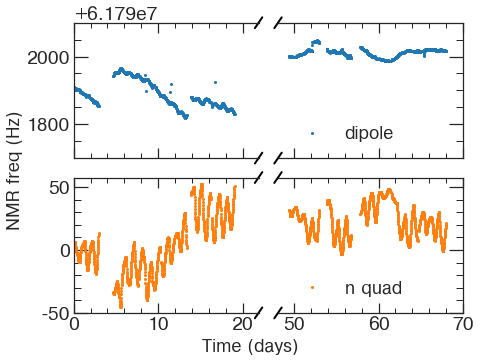

In [171]:
fig_name = 'fig_run1_track'

fig5, axs5 = plt.subplots(2, 2)

axs5[0,0].plot(x, y1 + 61.74e6, '.', ms=4)
axs5[0,0].set_xlim([0,21.9])
axs5[0,0].set_ylim([1700 + 61.79e6,2100 + 61.79e6])
axs5[0,1].plot(x, y1 + 61.74e6 - 61.79e6, '.', ms=4, label='dipole')
axs5[0,1].set_xlim([48.1,70])
axs5[0,1].set_ylim([1700,2100])

axs5[0,0].spines['right'].set_visible(False)
axs5[0,1].spines['left'].set_visible(False)
axs5[0,0].tick_params(which='both', right=False, labelbottom=False)
axs5[0,1].tick_params(which='both', left=False, labelleft=False, labelbottom=False)

axs5[1,0].plot(x, y2, '.', ms=4, color='C1')
axs5[1,0].set_xlim([0,21.9])
axs5[1,1].plot(x, y2, '.', ms=4, label='n quad', color='C1')
axs5[1,1].set_xlim([48.1,70])

axs5[1,0].spines['right'].set_visible(False)
axs5[1,1].spines['left'].set_visible(False)
axs5[1,0].tick_params(which='both', right=False)
axs5[1,1].tick_params(which='both', left=False, labelleft=False)

axs5[0,1].legend()
axs5[1,1].legend()

fig5.text(0, 0.5, 'NMR freq (Hz)', va='center', rotation='vertical')
fig5.text(0.5, 0, 'Time (days)', ha='center')


d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axs5[0,0].transAxes, color='k', clip_on=False)
axs5[0,0].plot((1-d, 1+d), (1-2*d, 1+2*d), **kwargs)        # top-left diagonal
axs5[0,0].plot((1-d, 1+d), (-2*d, 2*d), **kwargs)  # botton-left diagonal

kwargs = dict(transform=axs5[1,0].transAxes, color='k', clip_on=False)
axs5[1,0].plot((1-d, 1+d), (1-2*d, 1+2*d), **kwargs)        # top-left diagonal
axs5[1,0].plot((1-d, 1+d), (-2*d, 2*d), **kwargs)  # botton-left diagonal

kwargs = dict(transform=axs5[0,1].transAxes, color='k', clip_on=False)
axs5[0,1].plot((-d, d), (1-2*d, 1+2*d), **kwargs)        # top-right diagonal
axs5[0,1].plot((-d, d), (-2*d, 2*d), **kwargs)  # botton-right diagonal

kwargs = dict(transform=axs5[1,1].transAxes, color='k', clip_on=False)
axs5[1,1].plot((-d, d), (1-2*d, 1+2*d), **kwargs)        # top-right diagonal
axs5[1,1].plot((-d, d), (-2*d, 2*d), **kwargs)  # botton-right diagonal


fig5.set_size_inches(fig_width, 0.75*fig_width)
fig5.tight_layout()

fig5.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
pickle.dump(axs5, open('figures/run_1/'+fig_name+'.pickle', 'wb'))


In [193]:
## fig:run1_map

fig_name = 'fig_run1_map'

df = pd.DataFrame()
for run in map_config.subruns:
    print run
    _df = pd.read_hdf('/data2/aetb/2020-09-30_purcell_maps.h5', key='run_'+run)
    _df = _df.groupby(pd.cut(_df.index.values, _df.shape[0]/1200)).mean()
    new_index = np.arange(len(_df.index))
    for i in range(len(_df.index)):
        new_index[i] = _df.index[i].mid
    _df.index = new_index
    if run == '1a1': df = _df.copy()
    else: df = df.append(_df)
    
for m in range(9):
    stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
    df['m'+str(m+1)] = df[stm].multiply(weight).sum(axis=1)

1a1
1b1
1b2
1c1
1c2
1c3
1d2
1d3
1d4
1d5
1d6


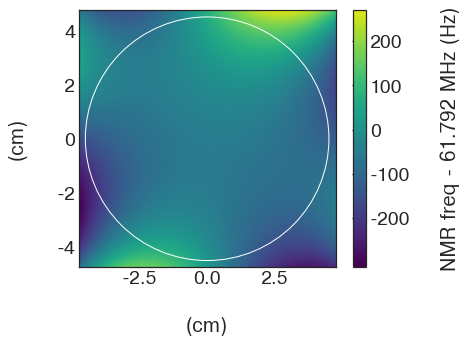

In [239]:
fig_name = 'fig_run1_map'

X, Y = np.meshgrid(np.linspace(-4.75,4.75,1001), np.linspace(-4.75,4.75,1001))

B = X*0

for m in range(9):
    amp = np.polyfit(df.index.values, df['m'+str(m+1)].values, 0)
    if m == 0: amp -= 52e3
    order = trfp.matrices._MULTIPOLE_ORDER[m]
    skew = trfp.matrices._MULTIPOLE_SKEW[m]
    B += trfp.matrices.__multipole(order, skew, amp, X, Y)

fig6, axs6 = plt.subplots(1)

map6 = axs6.contourf(X, Y, B, levels=500, cmap='viridis', vmin=-300, vmax=300)
axs6.set_aspect('equal')

axs6.add_artist(plt.Circle((0, 0), 4.5, fill=False))

axs6.set_xlabel('(cm)')
axs6.set_ylabel('(cm)')

cbar6 = fig6.colorbar(map6, shrink=1, ticks=[-200, -100, 0, 100, 200])
cbar6.set_label('NMR freq - 61.792 MHz (Hz)')

fig6.set_size_inches(fig_width, .75*fig_width)
fig6.tight_layout()

fig6.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
pickle.dump(axs6, open('figures/run_1/'+fig_name+'.pickle', 'wb'))
